# 데이터 불러오기

In [12]:
DATA_PATH = "../딸기/data/" # 데이터 경로

In [13]:
import numpy as np
import pandas as pd

train_trans = pd.read_csv(f"{DATA_PATH}x_train.csv")
train_target = pd.read_csv(f"{DATA_PATH}y_train.csv")
test_trans = pd.read_csv(f"{DATA_PATH}x_test.csv")
submit = pd.read_csv(f"{DATA_PATH}submission.csv")

train_trans.shape, train_target.shape, test_trans.shape, submit.shape

((22176, 30), (154, 2), (9504, 30), (66, 2))

# rnn-cnn 모델 추론

In [14]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def test_loop(dataloader,model,loss_fn,device):
    """
    모델 검증 및 추론 기능 함수
    """
    epoch_loss = 0
    model.eval()
    pred_list = []
    for batch in dataloader:

        pred = model(batch["seq"].to(device),batch["tb"].to(device))
        if batch.get("y") is not None:
            loss = loss_fn(pred, batch["y"].to(device))
            epoch_loss += loss.item()

        pred = pred.to("cpu").numpy()
        pred_list.append(pred)

    epoch_loss /= len(dataloader)
    pred = np.concatenate(pred_list)
    return epoch_loss , pred

class TorchDataset(torch.utils.data.Dataset):
    """
    데이터셋 클래스
    """
    def __init__(self ,seq, tb , y = None):
        self.seq = seq
        self.tb = tb
        self.y = y
    def __len__(self):
        return len(self.seq)
    def __getitem__(self, idx):
        item = {}
        item["seq"] = torch.Tensor(self.seq[idx])
        item["tb"] = torch.Tensor(self.tb[idx])
        if self.y is not None:
            item["y"] = torch.Tensor(self.y[idx])
        return item
    
class ResidualBlock(torch.nn.Module):
    """
    잔차 블록 레이어 클래스
    """
    def __init__(self, in_features, act):
        super().__init__()
        self.fx = torch.nn.Sequential(
            torch.nn.Linear(in_features, in_features),
            act,
            torch.nn.Dropout(0.5),
            torch.nn.Linear(in_features, in_features)
        )
        self.act = act

    def forward(self, x):
        fx = self.fx(x)
        hx = fx + x
        return self.act(hx)

class Net(torch.nn.Module):
    """
    모델 클래스
    """
    def __init__(self, n_features,in_features, lstm_hidden=128, act_conv1d="leaky_relu", act_init="leaky_relu",act_res="relu",
                  n_layers = 4, **kwarg):
        super().__init__()
        self.act_dict = {
            "relu" : torch.nn.ReLU(),
            "leaky_relu" : torch.nn.LeakyReLU(),
            "prelu" : torch.nn.PReLU(),
            "elu" : torch.nn.ELU(),
            "silu" : torch.nn.SiLU(),
            "gelu" : torch.nn.GELU(),
        }
        
        self.lstm_layer = torch.nn.LSTM(n_features, lstm_hidden, batch_first=True)   
        self.conv1d_block = torch.nn.Sequential( # input shape: B, F, S
            torch.nn.Conv1d(lstm_hidden, lstm_hidden*2, 3),
            self.act_dict[act_conv1d],
            torch.nn.MaxPool1d(2),
            torch.nn.Conv1d(lstm_hidden*2, lstm_hidden*4, 3),
            self.act_dict[act_conv1d],
            torch.nn.MaxPool1d(2),
            torch.nn.AdaptiveAvgPool1d(1), # B, F, 1
            torch.nn.Flatten(), # B, F
        ) 

        self.init_layer = torch.nn.Sequential(
            torch.nn.Linear(in_features, in_features // 2),
            torch.nn.BatchNorm1d(in_features // 2),
            self.act_dict[act_init]
        )
        res_list = [ ResidualBlock(in_features//2, self.act_dict[act_res]) for _ in range(n_layers) ]
        self.res_seq = torch.nn.Sequential(*res_list)
    
        self.output_layer = torch.nn.Linear(lstm_hidden*4 + in_features//2, 1)
    def forward(self, seq, tb):
        output, (hn, cn) = self.lstm_layer(seq)
        seq = self.conv1d_block( output.permute(0, 2, 1) )  # input/output shape: B, F, S
        
        tb = self.init_layer(tb)
        tb = self.res_seq(tb)

        x = torch.cat([seq,tb],dim=1)
        return self.output_layer(x)


cols = ["DAT", "fan", "co2", "heater", "window1", "window2", "curtain1", "curtain2", "curtain3", "side_curtain", "rain_sensor",
 "crown_diameter", "petiole_length", "leaf_count", "leaf_length","leaf_width","fruit_count","plant_height",
 "flower_count","numbers of plant"]
agg_dict = {}
for col in cols:
    agg_dict[col] = [
        (f"{col}_mean","mean")
    ]

cols = ["in_temp","in_hum","in_co2","out_temp","out_hum","solar_rad","wind_speed","wind_direction"]

for col in cols:
    agg_dict[col] = [
        (f"{col}_mean","mean"),
        (f"{col}_min","min"),
        (f"{col}_max","max"),
        (f"{col}_skew","skew"),
        (f"{col}_kurt",lambda x: x.kurt()),
        (f"{col}_std","std"),
    ]

# 2차원 피처셋
tmp = train_trans.groupby("Sample_Number").agg(agg_dict)
tmp.columns = tmp.columns.droplevel()
tmp = tmp.reset_index()
train_ft = train_target.iloc[:,:1].merge(tmp, how="left", on="Sample_Number").drop(columns="Sample_Number")
tmp = test_trans.groupby("Sample_Number").agg(agg_dict)
tmp.columns = tmp.columns.droplevel()
tmp = tmp.reset_index()
test_ft = submit.iloc[:,:1].merge(tmp, how="left", on="Sample_Number").drop(columns="Sample_Number")
scaler = MinMaxScaler()
scaler.fit(train_ft)
test_ft = scaler.transform(test_ft)

# 3차원 피처셋
drop_cols = [ "Sample_Number","time",]
scaler.fit(train_trans.drop(columns=drop_cols))
test_data = scaler.transform(test_trans.drop(columns=drop_cols))
n = test_data.shape[1]
test_data = test_data.reshape(-1,144,n)

# 추론
hp = {
    "lstm_hidden":752,
    "act_conv1d":'relu',
    "act_init":'silu',
    "act_res":'relu',
    "n_layers":4,
    "lr": 0.0006,
    "batch_size": 16
}

test_dt = TorchDataset(test_data,test_ft)
test_dl = torch.utils.data.DataLoader(test_dt, batch_size=16,shuffle=False)
device = "cuda" if torch.cuda.is_available() else "cpu"
pred_list = []
for i in range(5):
    model = Net(test_data.shape[2], test_ft.shape[1], **hp).to(device) # 모델 객체 새로 생성
    state_dict = torch.load(f"model-rnncnn-{i}.pth")
    model.load_state_dict(state_dict)

    _ , pred = test_loop(test_dl,model,None,device)
    pred_list.append(pred)
    
pred_rnncnn = np.mean(pred_list,axis=0)
pred_rnncnn.shape

(66, 1)

# 머신러닝 모델 추론
- catboost, LightGBM ,random forest, XGBoost

In [15]:
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# ✅ 데이터 로드
x_test = test_trans
x_train = train_trans
y_train = train_target

# ✅ 컬럼 정의
env_cols = ['in_temp', 'in_hum', 'in_co2', 'out_temp', 'out_hum', 'solar_rad', 'wind_speed', 'wind_direction', 'rain_sensor']
growth_cols = ['plant_height', 'crown_diameter', 'petiole_length', 'leaf_count', 'leaf_length', 'leaf_width', 'fruit_count', 'flower_count']
actuator_cols = ['fan', 'co2', 'heater', 'window1', 'window2', 'curtain1', 'curtain2', 'curtain3', 'side_curtain']

# ✅ wind_direction 파생
for df in [x_test, x_train]:
    df['wind_direction_sin'] = np.sin(np.deg2rad(df['wind_direction']))
    df['wind_direction_cos'] = np.cos(np.deg2rad(df['wind_direction']))

# ✅ 공통 함수 (이전 학습 코드 그대로)
def calc_slope(series):
    y = series.values
    x = np.arange(len(y)).reshape(-1, 1)
    if len(y) < 2 or np.isnan(y).all():
        return np.nan
    try:
        lr = LinearRegression()
        lr.fit(x[~np.isnan(y)], y[~np.isnan(y)])
        return lr.coef_[0]
    except:
        return np.nan

def extract_basic_stats(group):
    result = {}
    for col in actuator_cols + env_cols:
        s = group[col]
        diff = s.diff()
        result.update({
            f'{col}_mean': s.mean(),
            f'{col}_std': s.std(),
            f'{col}_max': s.max(),
            f'{col}_min': s.min(),
            f'{col}_median': s.median(),
            f'{col}_slope': calc_slope(s),
            f'{col}_q80': s.quantile(0.8),
            f'{col}_q20': s.quantile(0.2),
            f'{col}_diffmean': diff.mean(),
            f'{col}_diffstd': diff.std(),
            f'{col}_increase_cnt': (diff > 0).sum(),
            f'{col}_decrease_cnt': (diff < 0).sum(),
            f'{col}_rolling3_mean': s.rolling(3, min_periods=1).mean().mean(),
            f'{col}_rolling6_std': s.rolling(6, min_periods=1).std().mean(),
            f'{col}_rolling3_max': s.rolling(3, min_periods=1).max().mean(),
            f'{col}_rolling3_min': s.rolling(3, min_periods=1).min().mean(),
            f'{col}_expanding_mean': s.expanding(min_periods=1).mean().iloc[-1],
        })
        if col in actuator_cols:
            result.update({
                f'{col}_on_ratio': (s == 1).mean(),
                f'{col}_on_off_switch_cnt': (diff != 0).sum(),
            })
    rain_diff = group['rain_sensor'].diff()
    result.update({
        'rain_sensor_sum': group['rain_sensor'].sum(),
        'rain_sensor_mean': group['rain_sensor'].mean(),
        'rain_sensor_diffmean': rain_diff.mean(),
        'rain_sensor_diffstd': rain_diff.std()
    })
    return result

def extract_wind_features(group):
    return {
        'wind_direction_sin_mean': group['wind_direction_sin'].mean(),
        'wind_direction_cos_mean': group['wind_direction_cos'].mean(),
        'wind_direction_sin_std': group['wind_direction_sin'].std(),
        'wind_direction_cos_std': group['wind_direction_cos'].std()
    }

def extract_temp_hum_diff(group):
    in_out_temp = group['in_temp'] - group['out_temp']
    in_out_hum = group['in_hum'] - group['out_hum']
    return {
        'temp_diff_mean': in_out_temp.mean(),
        'temp_diff_max': in_out_temp.max(),
        'temp_diff_min': in_out_temp.min(),
        'temp_diff_std': in_out_temp.std(),
        'hum_diff_mean': in_out_hum.mean(),
        'hum_diff_max': in_out_hum.max(),
        'hum_diff_min': in_out_hum.min(),
        'hum_diff_std': in_out_hum.std()
    }

def extract_growth_features(group):
    result = {}
    group = group.reset_index(drop=True)
    for col in growth_cols:
        s = group[col]
        result.update({
            f'{col}_first': s.iloc[0],
            f'{col}_last': s.iloc[-1],
            f'{col}_mean': s.mean(),
            f'{col}_median': s.median(),
            f'{col}_diff': s.iloc[-1] - s.iloc[0],
            f'{col}_slope': calc_slope(s),
            f'{col}_rolling3_mean': s.rolling(3, min_periods=1).mean().mean(),
            f'{col}_rolling3_std': s.rolling(3, min_periods=1).std().mean(),
        })
    return result

def extract_time_based_features(group):
    try:
        group['hour'] = pd.to_datetime(group['time'], errors='coerce').dt.hour
        result = {}
        for hour in [0, 6, 12, 18]:
            hour_temp = group[group['hour'] == hour]['in_temp']
            result[f'in_temp_hour{hour}_mean'] = hour_temp.mean() if not hour_temp.empty else np.nan
            result[f'in_temp_hour{hour}_std'] = hour_temp.std() if not hour_temp.empty else np.nan
        return result
    except:
        return {}

def extract_cumulative_features(group):
    result = {}
    for col in actuator_cols + env_cols:
        s = group[col]
        result[f'{col}_cumsum'] = s.cumsum().iloc[-1]
        result[f'{col}_cummean'] = s.expanding(min_periods=1).mean().iloc[-1]
    return result

def advanced_features_with_week_v2(df):
    feats = []
    for sample, group in df.groupby('Sample_Number'):
        d = {'Sample_Number': sample}
        d.update(extract_basic_stats(group))
        d.update(extract_wind_features(group))
        d.update(extract_temp_hum_diff(group))
        d.update(extract_growth_features(group))
        d.update(extract_time_based_features(group))
        d.update(extract_cumulative_features(group))
        feats.append(d)
    return pd.DataFrame(feats)

# ✅ 파생변수 생성
test_feats = advanced_features_with_week_v2(x_test)

# ✅ 학습 데이터 기반 top N 피처 재도출
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor


top_features = ['in_co2_q80',
 'leaf_length_first',
 'out_temp_mean',
 'co2_mean',
 'crown_diameter_slope',
 'in_temp_diffstd',
 'in_co2_q20',
 'out_temp_q80',
 'heater_rolling3_max',
 'curtain1_std',
 'side_curtain_diffstd',
 'fan_mean',
 'heater_rolling3_min',
 'curtain2_mean',
 'in_temp_hour18_mean',
 'curtain3_mean',
 'heater_rolling6_std',
 'curtain3_slope',
 'out_temp_q20',
 'out_temp_rolling3_max']
X_test = test_feats[top_features]

# ✅ 예측
def run_test_prediction(X_test: pd.DataFrame, n_splits: int = 5):
    pred_xgb = np.zeros(len(X_test))
    pred_lgb = np.zeros(len(X_test))
    pred_rf  = np.zeros(len(X_test))
    pred_cat = np.zeros(len(X_test))

    for i in range(n_splits):
        xgb = joblib.load(f"model-xgb-{i}.pkl")
        lgb = joblib.load(f"model-lgb-{i}.pkl")
        rf  = joblib.load(f"model-rf-{i}.pkl")
        cat = joblib.load(f"model-cat-{i}.pkl")

        pred_xgb += xgb.predict(X_test) / n_splits
        pred_lgb += lgb.predict(X_test) / n_splits
        pred_rf  += rf.predict(X_test)  / n_splits
        pred_cat += cat.predict(X_test) / n_splits

    print("XGB:", pred_xgb.shape)
    print("LGB:", pred_lgb.shape)
    print("RF :", pred_rf.shape)
    print("CAT:", pred_cat.shape)

    return pred_xgb, pred_lgb, pred_rf, pred_cat

# ✅ 실행
pred_xgb, pred_lgb, pred_rf, pred_cat = run_test_prediction(X_test)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_12548\2984611157.py:117: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  group['hour'] = pd.to_datetime(group['time'], errors='coerce').dt.hour
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_12548\2984611157.py:117: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  group['hour'] = pd.to_datetime(group['time'], errors='coerce').dt.hour
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_12548\2984611157.py:117: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  group['hour'] = pd.to_datetime(group['time'], errors='coe

XGB: (66,)
LGB: (66,)
RF : (66,)
CAT: (66,)


c:\Users\injec\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\injec\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.7.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


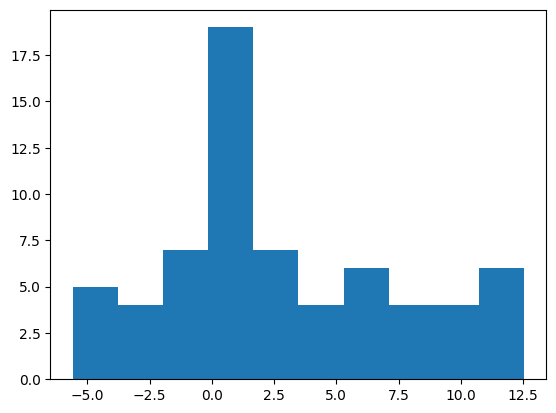

In [31]:
pred = np.mean([pred_xgb, pred_lgb, pred_rf, pred_cat, pred_rnncnn.reshape(-1)],axis=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(pred)
plt.show()

In [34]:
submit["CO2 final"] = pred
submit

,Sample_Number,CO2 final
0,6,1.196663
1,10,3.823969
2,16,6.171610
3,17,5.641934
4,19,4.382958
...,...,...
61,210,7.096248
62,211,5.818563
63,216,9.200701
64,218,12.538457


In [35]:
submit.to_csv("submission.csv", index=False)